In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [31]:
hyper_param_tuning = {
    'KNN': True,
    'LR': True,
    'RF': True,
    'XGBoost': True,
    'SVM': True,
    'MLP': True,
}

# Importing and preparing the dataset

The data is imported via the file output from preprocessing stage

In [3]:
df = pd.read_csv("./dataset/05_cleaned.csv")

# Removing the unnecessary columns other than first differance and a selected set of ordinaries
cols_to_remove = [col for col in df.columns if (
    ((col[:5] == 'team_') or (col[:9] == 'opponent_')) and
    ('rating' not in col) and
    ('xg' not in col) and
    ('probs' not in col))]
df = df.drop(cols_to_remove, axis='columns')

# Setting the independent variables and the target class
X = df.drop(['fulltime_result'], axis='columns')
y = df['fulltime_result']

# Helper functions and utilities

## Preparing the comparison table

This table is filled with the measurements of performance of various models, and is later used to compare the models and choose the best one for the current dataset.

In [4]:
evaluation_df = pd.DataFrame(
    columns=['Model',
             'DataSet',
             'Accuracy',
             'Precision',
             'Recall',
             'f1-score',]
)

## Initializing a pipeline

Here we create a pipeline with desired transformations and initialize it with the given estimator

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

def get_pipeline(model):
    # Passing all the columns except 'is_home' through the scaler
    cols_to_scale = [col for col in X.columns if col != 'is_home']

    # Initializing the standard-scaler
    col_transformer = ColumnTransformer(
        [('scaler', StandardScaler(), cols_to_scale)],
        remainder='passthrough')
    
    return Pipeline(
        [
            ('transformer', col_transformer),
            ('estimator', model),
        ]
    )

## Executing a given algorithm

This is the main body of code responsible for training and testing the model. It performes the following tasks:

<ol>
<li>Receives a model with its hyperparameters as input</li>
<li>Prepares a pipeline using the get_pipeline function</li>
<li>Fits the pipeline to the training data and tests it against both the training and the validation data</li>
<li>Returns the pipeline as output</li>
</ol>

In [6]:
from sklearn.model_selection import cross_validate
import sklearn.metrics as metrics

def execute_ml(model):
    # Preparing a pipeline using the input model
    pipeline = get_pipeline(model)

    # Running a cross validation and fetching the performance measurements
    cv = cross_validate(pipeline, X, y,
                        cv=10,
                        return_train_score=True,
                        scoring=('accuracy',
                                 'precision_macro',
                                 'recall_macro',
                                 'f1_macro'))
    
    # Calculating the mean of each score
    cv_result = pd.DataFrame(cv).mean()
    
    # Presenting the mean performance scores categorized as 'train' and 'test'
    for score_set in ['train', 'test']:
        set_info = [type(model).__name__, score_set]
        scores = list(
            cv_result[[idx for idx in cv_result.index if score_set in idx]])
        evaluation_df.loc[len(evaluation_df)] = set_info + scores

## Hyperparameter tuning

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

def grid_search(model, hyper_params):
    X_data, _, y_data, _ = train_test_split(
        X, y, stratify=y, random_state=12, train_size=.4, test_size=.1)
    
    gs = GridSearchCV(
        get_pipeline(model),
        param_grid=hyper_params, 
        n_jobs=-1, 
        cv=3, 
        scoring='accuracy',
        error_score=0,
        return_train_score=True,
        verbose=2,
    )

    res = gs.fit(X_data, y_data)

    print("Maximum accuracy of %f was yielded using: %s" % (res.best_score_, res.best_params_))

## Overfit analysis

In [8]:
def overfit_analysis(model, param_name, values):
    def draw_plot(results, index_col, cv_count):
        train_cols = [f"split{idx}_train_score" for idx in range(cv_count)]
        test_cols = [f"split{idx}_test_score" for idx in range(cv_count)]
        replace_dict = dict.fromkeys(train_cols, 'Train Score')
        replace_dict.update(dict.fromkeys(test_cols, 'Test Score'))

        results = (results.melt(id_vars=[index_col], 
                                value_vars=train_cols+test_cols,
                                var_name='score_type',
                                value_name='score')
                          .replace(replace_dict))

        lp = sns.lineplot(data=results, 
                          x=index_col,
                          y='score',
                          hue='score_type',
                          estimator=np.mean,
                          legend='full', ) 

        lp.legend(title='Score Type',)

        lp.set(
            xlabel=index_col[17:],
            ylabel='Score',
            title='Overfit Analysis')
    
    X_data, _, y_data, _ = train_test_split(
        X, y, stratify=y, random_state=12, train_size=.4, test_size=.1)
    
    cv_count = 3
    gs = GridSearchCV(
        get_pipeline(model),
        param_grid={param_name:values}, 
        n_jobs=-1, 
        cv=cv_count, 
        scoring='accuracy',
        error_score=0,
        return_train_score=True,
        verbose=2)

    res = pd.DataFrame(data = gs.fit(X_data, y_data).cv_results_)

    draw_plot(res, 'param_' + param_name, cv_count)

# Machine learning algorithms

Below, several different classification algorithms are implemented, executed, and the results are displayed for comparison within the evaluation table.

## K-Nearest Neighbours

### Hyperparameter Tuning

In [9]:
from sklearn.neighbors import KNeighborsClassifier

hyper_params = {}
hyper_params['estimator__n_neighbors'] = range(1, 31, 2)
hyper_params['estimator__weights'] = ['uniform']
hyper_params['estimator__metric'] = ['euclidean', 'manhattan', 'minkowski']

if hyper_param_tuning['KNN']:
    grid_search(KNeighborsClassifier(), hyper_params)

### Overfit analysis

Fitting 3 folds for each of 20 candidates, totalling 60 fits


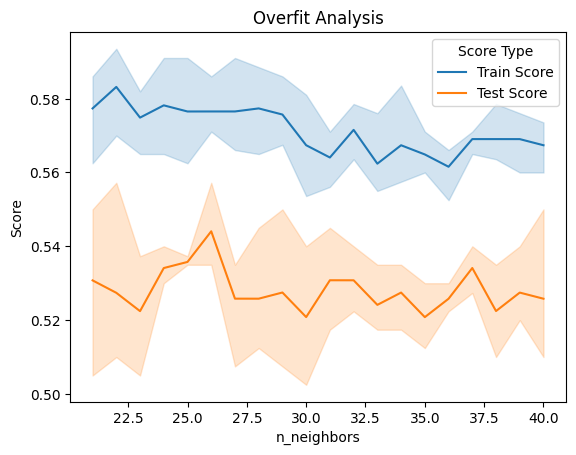

In [34]:
from sklearn.neighbors import KNeighborsClassifier

if hyper_param_tuning['KNN']:
    overfit_analysis(
        KNeighborsClassifier(
            metric='manhattan',
            weights='uniform'),
        'estimator__n_neighbors',
        range(21, 41))

### Train and test

In [11]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(
    metric='euclidean',
    n_neighbors=34,
    weights='uniform')

execute_ml(knn_clf)

## Logistic regression

### Hyperparameter Tuning

In [12]:
from sklearn.linear_model import LogisticRegression

hyper_params = {}
hyper_params['estimator__max_iter'] = [1000]
hyper_params['estimator__C'] = np.logspace(-3, 3, 7, endpoint=True)
hyper_params['estimator__solver'] = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
hyper_params['estimator__penalty'] = ['none', 'l1', 'l2', 'elasticnet']

if hyper_param_tuning['LR']:
    grid_search(LogisticRegression(), hyper_params)

### Train and test

In [39]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(
    C=.05,
    max_iter=1000,
    penalty='l1',
    solver='saga')

execute_ml(lr_clf)

## Random forest

### Hyperparameter Tuning

In [14]:
from sklearn.ensemble import RandomForestClassifier

hyper_params = {}
hyper_params['estimator__bootstrap']= [True, False]
hyper_params['estimator__max_features'] = ['sqrt', 'log2']
hyper_params['estimator__criterion'] = ['gini', 'entropy']

if hyper_param_tuning['RF']:
    grid_search(RandomForestClassifier(), hyper_params)

### Overfit analysis

Fitting 3 folds for each of 31 candidates, totalling 93 fits


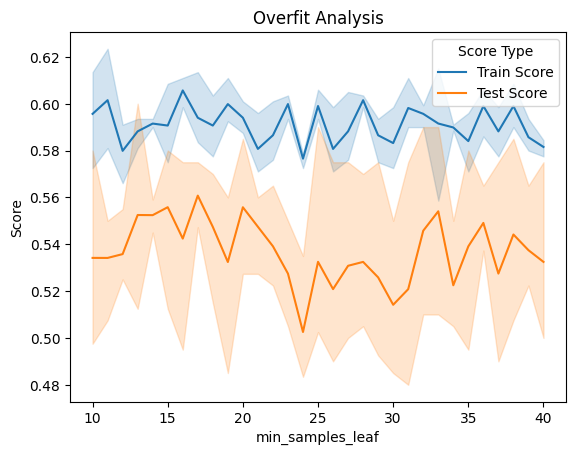

In [68]:
from sklearn.ensemble import RandomForestClassifier

values_range = range(10,41)

if hyper_param_tuning['RF']:
    overfit_analysis(
        RandomForestClassifier(
            bootstrap=True,
            criterion='gini',
            max_features='sqrt',
            min_samples_split=.2,
            max_depth=1,),
        'estimator__min_samples_leaf',
        values_range)

### Train and test

In [73]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    bootstrap=True,
    criterion='gini',
    max_features='sqrt',
    min_samples_split=.2,
    min_samples_leaf=30,
    max_depth=1,)

execute_ml(rf_clf)

## XGBoost classifier

### Hyperparameter Tuning

In [17]:
from xgboost import XGBClassifier

hyper_params = {}
hyper_params['estimator__learning_rate'] = list(
    np.logspace(-3, 0, 4, endpoint=True))
hyper_params['estimator__n_estimators'] = [10, 100, 500, 1000]
hyper_params['estimator__max_depth'] = list(range(1, 11, 2))

if hyper_param_tuning['XGBoost']:
    grid_search(XGBClassifier(), hyper_params)

### Overfit analysis

In [18]:
from xgboost import XGBClassifier

if hyper_param_tuning['XGBoost']:
    overfit_analysis(
        XGBClassifier(
            learning_rate=0.1,
            max_depth=3,
            n_estimators=100,),
        'estimator__subsample',
        np.arange(.01, .03, .001))

### Train and test

In [95]:
from xgboost import XGBClassifier

xgboost_clf = XGBClassifier(
    learning_rate=0.05,
    max_depth=2,
    n_estimators=15,
    subsample=.02)

execute_ml(xgboost_clf)

## Support Vector Machine classifier

### Hyperparameter Tuning

In [20]:
from sklearn import svm

hyper_params = {}
hyper_params['estimator__C']=(list(np.logspace(-1, 3, 5)) +
                              list(range(5000, 10000, 1000)))
hyper_params['estimator__gamma']=list(np.logspace(-4, 0, 5))
hyper_params['estimator__kernel'] = ['linear', 'poly', 'sigmoid', 'rbf']

if hyper_param_tuning['SVM']:
    grid_search(svm.SVC(), hyper_params) 

### Overfit analysis

Fitting 3 folds for each of 9 candidates, totalling 27 fits


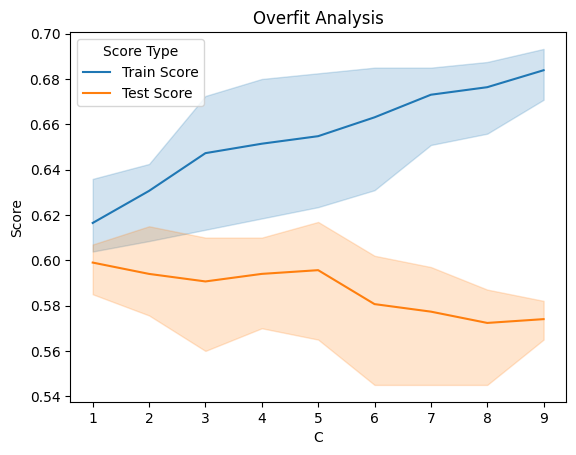

In [103]:
from sklearn import svm

values_range = list(range(1, 10))

if hyper_param_tuning['SVM']:
    overfit_analysis(
        svm.SVC(
            gamma=0.005,
            kernel='rbf'),
        'estimator__C',
        values_range)

### Train and test

In [104]:
from sklearn import svm

svm_clf = svm.SVC(
    C=1,
    gamma=0.005,
    kernel='rbf')

execute_ml(svm_clf)

## Multilayer perceptron

### Hyperparameter Tuning

In [23]:
from sklearn.neural_network import MLPClassifier

hyper_params = {}
hyper_params['estimator__hidden_layer_sizes']=[
    # (100,), (50,), (25,),
    (50,25),(100,50),
    (100,50,25),
    (100,50,25, 12),
]
hyper_params['estimator__max_iter']=[1500]
hyper_params['estimator__random_state'] = [12]
hyper_params['estimator__activation']=['tanh', 'relu', 'logistic']
hyper_params['estimator__solver']=['sgd', 'adam', 'lbfgs']
hyper_params['estimator__learning_rate']=['constant','adaptive','invscaling']

if hyper_param_tuning['MLP']:
    grid_search(MLPClassifier(), hyper_params)

### Overfit analysis

In [24]:
from sklearn.neural_network import MLPClassifier

values_range = np.linspace(0,.1,11)

if hyper_param_tuning['MLP']:
    overfit_analysis(
        MLPClassifier(
            activation='tanh',
            hidden_layer_sizes=(100, 50, 25),
            learning_rate='constant',
            max_iter=1500,
            random_state=12,
            solver='adam'),
        'estimator__alpha',
        values_range)

### Train and test

In [25]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(
    activation='tanh',
    hidden_layer_sizes=(100, 50, 25),
    learning_rate='adaptive',
    max_iter=1500,
    random_state=12,
    solver='adam',
    alpha=.09)

execute_ml(mlp_clf)

### Learning rate

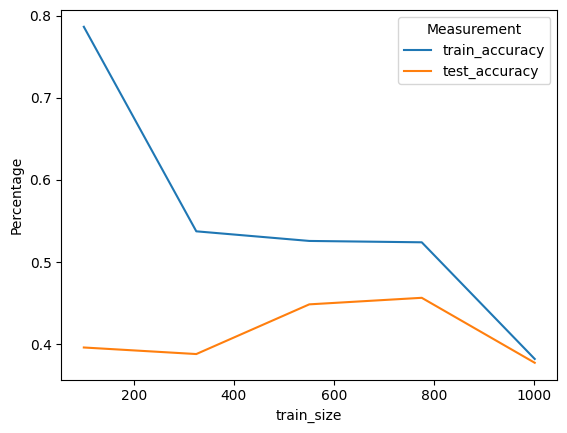

In [26]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    mlp_clf, X, y,
    cv=3,
    n_jobs=-1,
    random_state=12,)

data = {
    'train_size': list(train_sizes),
    'train_accuracy': [cv.mean() for cv in train_scores],
    'test_accuracy': [cv.mean() for cv in test_scores],
}
data_df = pd.melt(pd.DataFrame(data), 
                  id_vars='train_size', 
                  value_vars=['train_accuracy', 'test_accuracy'],
                  var_name='Measurement',
                  value_name='Percentage')

sns.lineplot(data=data_df, x='train_size', y='Percentage', hue='Measurement');

# Evaluation

In [105]:
from IPython.display import display
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(evaluation_df) 

,Model,DataSet,Accuracy,Precision,Recall,f1-score
0,KNeighborsClassifier,train,0.560214,0.593315,0.560213,0.560818
1,KNeighborsClassifier,test,0.508305,0.560003,0.508340,0.501196
2,LogisticRegression,train,0.573520,0.569306,0.573521,0.569622
3,LogisticRegression,test,0.540291,0.543719,0.540392,0.526915
4,RandomForestClassifier,train,0.656540,0.655730,0.656540,0.655661
5,RandomForestClassifier,test,0.537673,0.549038,0.537699,0.520356
6,XGBClassifier,train,0.600357,0.600532,0.600357,0.599849
7,XGBClassifier,test,0.528993,0.533529,0.528915,0.519117
8,SVC,train,0.590745,0.595940,0.590745,0.592388
9,SVC,test,0.545629,0.564529,0.545634,0.536919


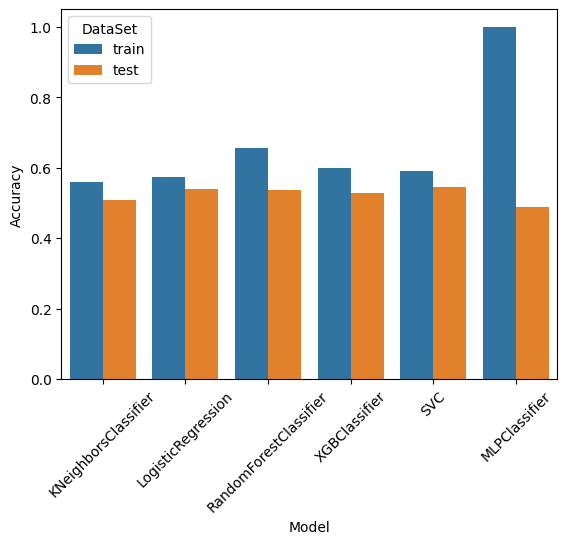

In [28]:
sns.barplot(data=evaluation_df, x='Model', y='Accuracy', hue='DataSet')
plt.xticks(rotation=45);

# Selecting the optimal model

In [29]:
# Selecting the model with the best performance
pipeline = get_pipeline(mlp_clf)

# Training the selected model with all of the data (including the test set)
pipeline.fit(X, y)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['team_win_bet365_probs',
                                                   'team_pre_rating', 'team_xg',
                                                   'opponent_win_bet365_probs',
                                                   'opponent_pre_rating',
                                                   'opponent_xg',
                                                   'fd_team_fulltime_goals',
                                                   'fd_team_win_bet365_probs',
                                                   'fd_team_total_shots',
                                                   'fd_team_shots_on_target',
                                                   'fd_team_shots_off_...
                                                   'fd_team_xg',
                                                   'fd_opponent_fulltime_goals',
                                                   'fd_opponent_win_bet365_probs',
                                                   'fd_opponent_total_shots',
                                                   'fd_opponent_shots_on_target',
                                                   'fd_opponent_shots_off_target',
                                                   'fd_opponent_clear_cut_chances',
                                                   'fd_opponent_xg'])])),
                ('estimator',
                 MLPClassifier(activation='tanh', alpha=0.09,
                               hidden_layer_sizes=(100, 50, 25),
                               learning_rate='adaptive', max_iter=1500,
                               random_state=12))])

# Exporting the trained model

In order to avoid training the model each time a prediction is needed, the trained model is saved into a file and from then on, for each prediction, the already trained model is loaded from the file and used.

In [30]:
import joblib

# Saving the trained model into a file
joblib.dump(pipeline, "./trained_models/model_ordinary.joblib")

['./trained_models/model_ordinary.joblib']